In [1]:
# Use our best model, the LOGREG + OHE

In [2]:
# References
# https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# https://stackoverflow.com
# https://www.youtube.com/watch?v=b5F667g1yCk&list=PLZoTAELRMXVPgsojPOHF9i0u2L83-m9P7&index=4&ab_channel=KrishNaik
# Past group project

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

# Import and initial cleaning

In [4]:
print("Current Working Directory " , os.getcwd())
data = pd.read_csv ('finantier_data_technical_test_dataset.csv',index_col=False) # if index_col not set, pandas assumes ID as index due to the error_error text on the right side 
print(data.head())
# 7048 rows x 22 columns
data = data.drop('Unnamed: 21',axis =1) # drop last col containing error_error
data = data.dropna()  # drop rows with nan values, checked that we are losing a small amount of data only (5points)
print(data.head())      
# 7043 rows x 21 columns

Current Working Directory  C:\Users\aaroncode\Desktop\Finantier
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  4808-GHDJN  Female            NaN     NaN        NaN     NaN          NaN   
1  7590-VHVEG  Female            0.0     Yes         No     1.0           No   
2  5575-GNVDE    Male            0.0      No         No    34.0          Yes   
3  3668-QPYBK    Male            0.0      No         No     2.0          Yes   
4  7795-CFOCW    Male            0.0      No         No    45.0           No   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0               NaN             NaN            NaN  ...         NaN   
1  No phone service             DSL             No  ...          No   
2                No             DSL            Yes  ...          No   
3                No             DSL            Yes  ...          No   
4  No phone service             DSL            Yes  ...         Yes   

  StreamingTV StreamingMovie

# Feature selection & conversion using domain knowledge

In [5]:
y = data.Default                         # Yes or No
list = ['Default','customerID','PaymentMethod','PaperlessBilling']
x = data.drop(list,axis = 1 )          # Drop unneccessary fields from features
x.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges
1,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,29.85,29.85
2,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,56.95,1889.5
3,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15
4,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75
5,Female,0.0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,70.70,151.65


In [6]:
# Convert Default col values (No Default, Default) to (0,1)
y = (y == 'Yes').astype(int)

# Recognise, gender, Partner, Dependents and PhoneService can also be changed to 0,1 values 

# Change gender from (Male,Female) -> (0,1) respectively
x['gender'] = (x['gender'] == 'Female').astype(int)
# Change partner, dependents from (No,Yes) -> (0,1) respectively
x['Partner'] = (x['Partner'] == 'Yes').astype(int)
x['Dependents'] = (x['Dependents'] == 'Yes').astype(int)
x['PhoneService'] = (x['PhoneService'] == 'Yes').astype(int)
# Convert SeniorCitizen to int for good measure
x['SeniorCitizen'] = x['SeniorCitizen'].astype(int)
x['TotalCharges'] = x['TotalCharges'].replace(r'^\s+$',0,regex = True)
x['TotalCharges'] = pd.to_numeric(x['TotalCharges'])
print(x.describe())

            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7043.000000    7043.000000  7043.000000  7043.000000  7043.000000   
mean      0.495244       0.162147     0.483033     0.299588    32.371149   
std       0.500013       0.368612     0.499748     0.458110    24.559481   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       0.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MonthlyCharges  TotalCharges  
count   7043.000000     7043.000000   7043.000000  
mean       0.903166       64.761692   2279.734304  
std        0.295752       30.090047   2266.794470  
min        0.000000       18.250000      0.000000  
25%        1.000000       35.500000    398.550000  
50%

# SMOTE + Logistic Regression + OHE

In [8]:
import category_encoders as ce

#Create target encoding object
encoder= ce.OneHotEncoder()


#Fit and Transform Train Data
encoder.fit(x)
x = encoder.transform(x)

#Pickle encoder for use in API
import pickle
pickle_out = open("encoder.pkl","wb")
pickle.dump(encoder, pickle_out)
pickle_out.close()
x

C:\Users\aaroncode\AppData\Roaming\Python\Python38\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,...,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract_1,Contract_2,Contract_3,MonthlyCharges,TotalCharges
1,1,0,1,0,1.0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,29.85,29.85
2,0,0,0,0,34.0,1,0,1,0,1,...,0,0,1,0,0,0,1,0,56.95,1889.50
3,0,0,0,0,2.0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,53.85,108.15
4,0,0,0,0,45.0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,42.30,1840.75
5,1,0,0,0,2.0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7043,0,0,1,1,24.0,1,0,0,1,1,...,1,0,0,1,0,0,1,0,84.80,1990.50
7044,1,0,1,1,72.0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,103.20,7362.90
7045,1,0,1,1,11.0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,29.60,346.45
7046,0,1,1,0,4.0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,74.40,306.60


In [9]:
# Splitting into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

# from imblearn.over_sampling import SMOTE
# os = SMOTE(random_state=0)
# X_train_os,y_train_os=os.fit_resample(X_train, y_train)
# X_train,y_train=os.fit_resample(X_train, y_train)
# Unfortunately SMOTE increases train accuracy only and decreases AUC score

In [10]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
# Create your classifier here
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(random_state = 0,max_iter =220)    # Found 250 by trial error
logmodel.fit(X_train, y_train)


LogisticRegression(max_iter=220, random_state=0)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.801419878296146

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7988641741599621



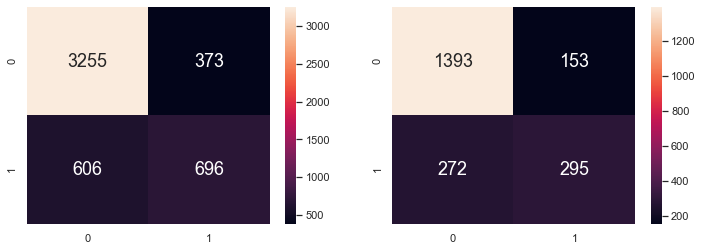

In [11]:
# Actual class predictions
rf_predictions1 = logmodel.predict(X_train)
rf_predictions = logmodel.predict(X_test)

# Probabilities for each class

rf_probs = logmodel.predict_proba(X_test)
rf_probs

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", logmodel.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", logmodel.score(X_test, y_test))
print()

from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, rf_predictions1), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, rf_predictions), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Average precision score: 0.657


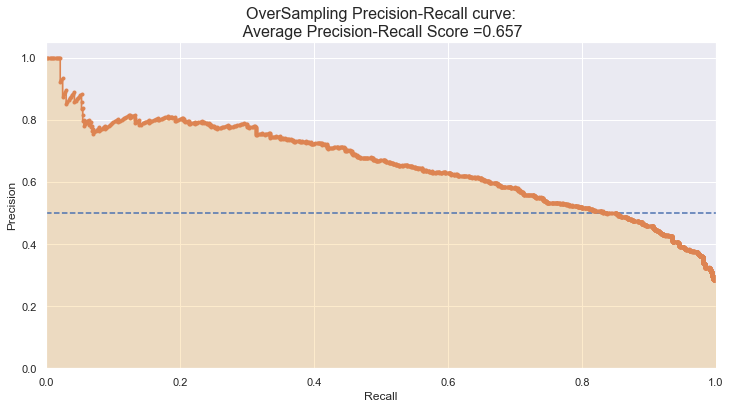

AUC: 0.656


In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
rf_predictions = logmodel.predict_proba(X_test) # actual outputs from the model
average_precision = average_precision_score(y_test, rf_predictions[:,1])
print("Average precision score: {:.3f}".format(average_precision))
# Improvement from non-smote 0.612

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, rf_predictions[:,1])

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve:\n Average Precision-Recall Score ={0:0.3f}'.format(
          average_precision), fontsize=16)
precision, recall, thresholds = precision_recall_curve(y_test,rf_predictions[:,1])
auc_score = auc(recall, precision)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()
print('AUC: %.3f' % auc_score)
# AUC 0.656

In [13]:
# Pickling my model into the file "model.pkl"
import pickle
pickle_out = open("model.pkl","wb")
pickle.dump(logmodel, pickle_out)
pickle_out.close()

In [17]:
# Test input
{
  "customerID": "7314-OXENN",
  "gender": "Male",
  "SeniorCitizen": 0,
  "Partner": "No",
  "Dependents": "No",
  "tenure": 2,
  "PhoneService": "Yes",
  "MultipleLines": "Yes",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "No",
  "OnlineBackup": "Yes",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "No",
  "StreamingMovies": "No",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check",
  "MonthlyCharges": 82,
  "TotalCharges": "184.65"
}
# produce likely to default result

{'customerID': '7314-OXENN',
 'gender': 'Male',
 'SeniorCitizen': 0,
 'Partner': 'No',
 'Dependents': 'No',
 'tenure': 2,
 'PhoneService': 'Yes',
 'MultipleLines': 'Yes',
 'InternetService': 'Fiber optic',
 'OnlineSecurity': 'No',
 'OnlineBackup': 'Yes',
 'DeviceProtection': 'No',
 'TechSupport': 'No',
 'StreamingTV': 'No',
 'StreamingMovies': 'No',
 'Contract': 'Month-to-month',
 'PaperlessBilling': 'Yes',
 'PaymentMethod': 'Electronic check',
 'MonthlyCharges': 82,
 'TotalCharges': '184.65'}

In [18]:
{
  "customerID": "7538-GWHML",
  "gender": "Female",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "No",
  "tenure": 72,
  "PhoneService": "Yes",
  "MultipleLines": "Yes",
  "InternetService": "Fiber optic",
  "OnlineSecurity": "Yes",
  "OnlineBackup": "Yes",
  "DeviceProtection": "Yes",
  "TechSupport": "No",
  "StreamingTV": "Yes",
  "StreamingMovies": "Yes",
  "Contract": "Two year",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Credit card (automatic)",
  "MonthlyCharges":110.65 , 
  "TotalCharges": "85.65"
}
# this will produce unlikely to default result

{'customerID': '7538-GWHML',
 'gender': 'Female',
 'SeniorCitizen': 0,
 'Partner': 'Yes',
 'Dependents': 'No',
 'tenure': 72,
 'PhoneService': 'Yes',
 'MultipleLines': 'Yes',
 'InternetService': 'Fiber optic',
 'OnlineSecurity': 'Yes',
 'OnlineBackup': 'Yes',
 'DeviceProtection': 'Yes',
 'TechSupport': 'No',
 'StreamingTV': 'Yes',
 'StreamingMovies': 'Yes',
 'Contract': 'Two year',
 'PaperlessBilling': 'Yes',
 'PaymentMethod': 'Credit card (automatic)',
 'MonthlyCharges': 110.65,
 'TotalCharges': '85.65'}